# Radial Advection LaSDI-LS Example (MFEM Example 9)

In [ ]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import pickle
from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.io import savemat,loadmat
import scipy.integrate as integrate
import os
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

### Import training simulations, parameters, etc.

In [2]:
# ### Load Data if Model Already Exists ###
snapshot_full = np.array([])
Training_values = [.95,1.05]
for i in Training_values:
    ex = np.load('./data/ex9_interp_{}.npz'.format(int(i*100)), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot_full = np.append(snapshot_full, ex)
snapshot_full = snapshot_full.reshape(len(Training_values)*240,-1)
# snapshot_full = snapshot_full.T
nx = 64
ny = 64
m = (ny-2)*(nx-2) # 3364
nt = 240
tstop = 3
dt = tstop/nt

In [4]:
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

snapshot_full = snapshot_full[:,free_raveled_indicies].T

[xv,yv]=np.meshgrid(np.linspace(-1,1,nx),np.linspace(-1,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

### Generate POD from training data

In [27]:
u,s,vh = LA.svd(snapshot_full)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

5 [0.38457669 0.67070998 0.83864514 0.90969918 0.96000412]


(1e-07, 10000)

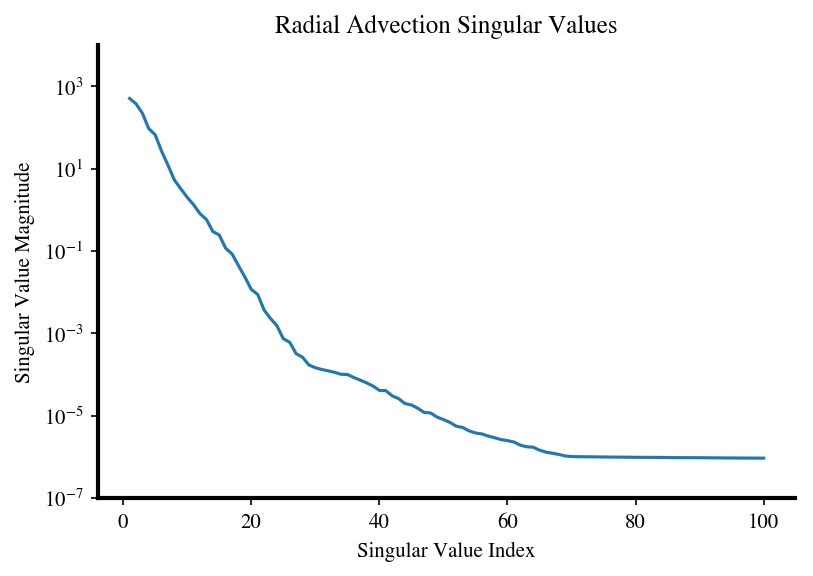

In [28]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,101),s[:100])
ax.set_title('Radial Advection Singular Values')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value Magnitude')
ax.set_yscale('log')
ax.set_ylim(10e-8,10000)

### Generate latent-space trajectories from training simulations

In [30]:
amp_arr = np.array([.95,1.05])
width_arr = np.array([1])

P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[1]
nset = int(ndata/(nt+1))

latent_space_SS = []

for foo in range(nset):
    latent_space = np.matmul(phi.T, snapshot_full[:, nt*foo:nt*(foo+1)])
    latent_space_SS.append(latent_space.T)

### Generate LaSDI-LS Model

x0' = 0.233 1 + 0.207 x0 + 0.634 x1 + -0.174 x2 + -0.156 x3 + -0.256 x4
x1' = 0.706 1 + 0.044 x0 + -0.074 x1 + -1.555 x2 + 0.011 x3 + -1.113 x4
x2' = -1.428 1 + -1.436 x0 + 1.307 x1 + 0.804 x2 + 1.322 x3 + 1.577 x4
x3' = -1.966 1 + -1.703 x0 + 0.194 x1 + -0.330 x2 + -0.078 x3 + 4.959 x4
x4' = -2.617 1 + -2.746 x0 + 0.333 x1 + 1.464 x2 + -0.985 x3 + 2.881 x4


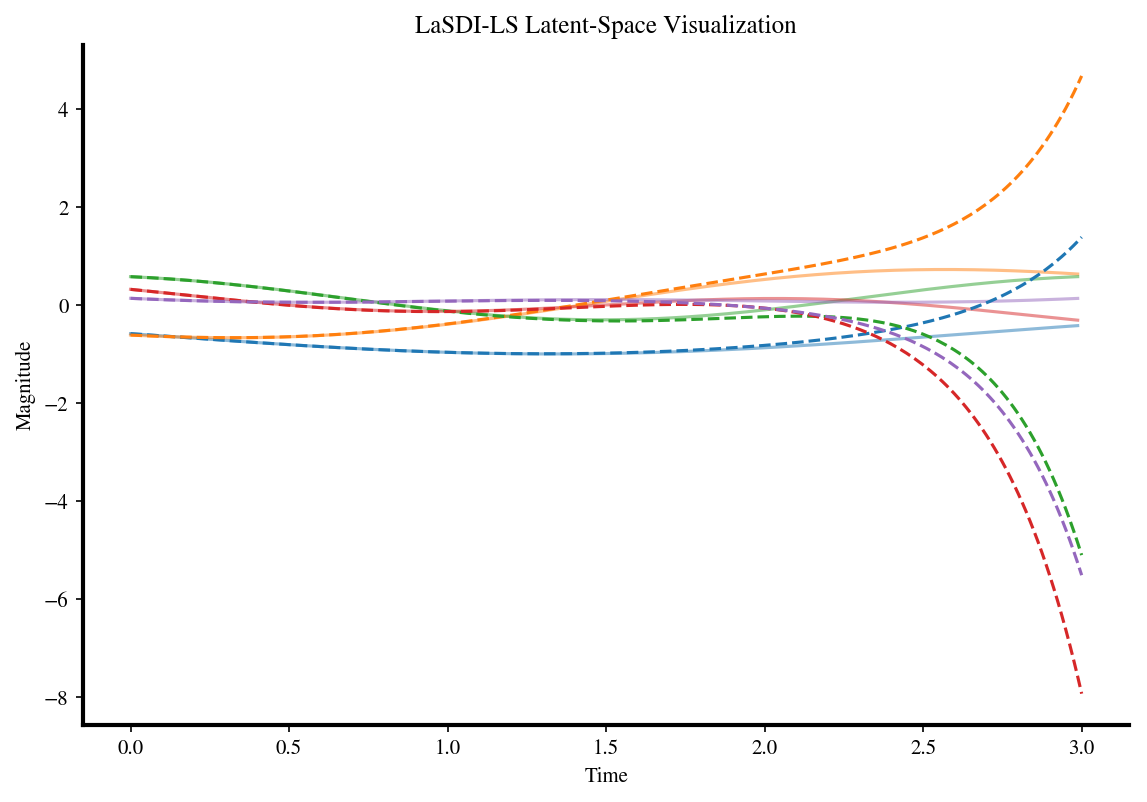

In [32]:
degree = 1
LaSDI_model = LaSDI(phi.T, phi, NN = False)
normal = np.amax(np.abs(latent_space_SS))
LaSDI_model.train_dynamics(latent_space_SS, P, dt, degree = degree, normal = normal, include_interaction = True)

### Generate ROM and visualize results

In [10]:
FOM_file = np.load('./data/ex9_interp_100.npz', allow_pickle = True)
FOM = FOM_file.f.arr_0
FOM = FOM[:,free_raveled_indicies]
start = time.time()
t = np.arange(0,tstop,dt)
FOM_recon = LaSDI_model.generate_ROM(FOM[0], np.array([1.0,1.0]),t)
LaSDI_time = time.time()-start
speed_up = 14.5/LaSDI_time
test = []
for k in range(int(nt-1)):
    test.append(LA.norm(FOM_recon[k].reshape(ny-2,nx-2)-FOM[k].reshape(ny-2,nx-2))/LA.norm(FOM[k].reshape(ny-2,nx-2))*100)
max_re = np.amax(test)

Text(0.5, 1.0, 'Absolute Error')

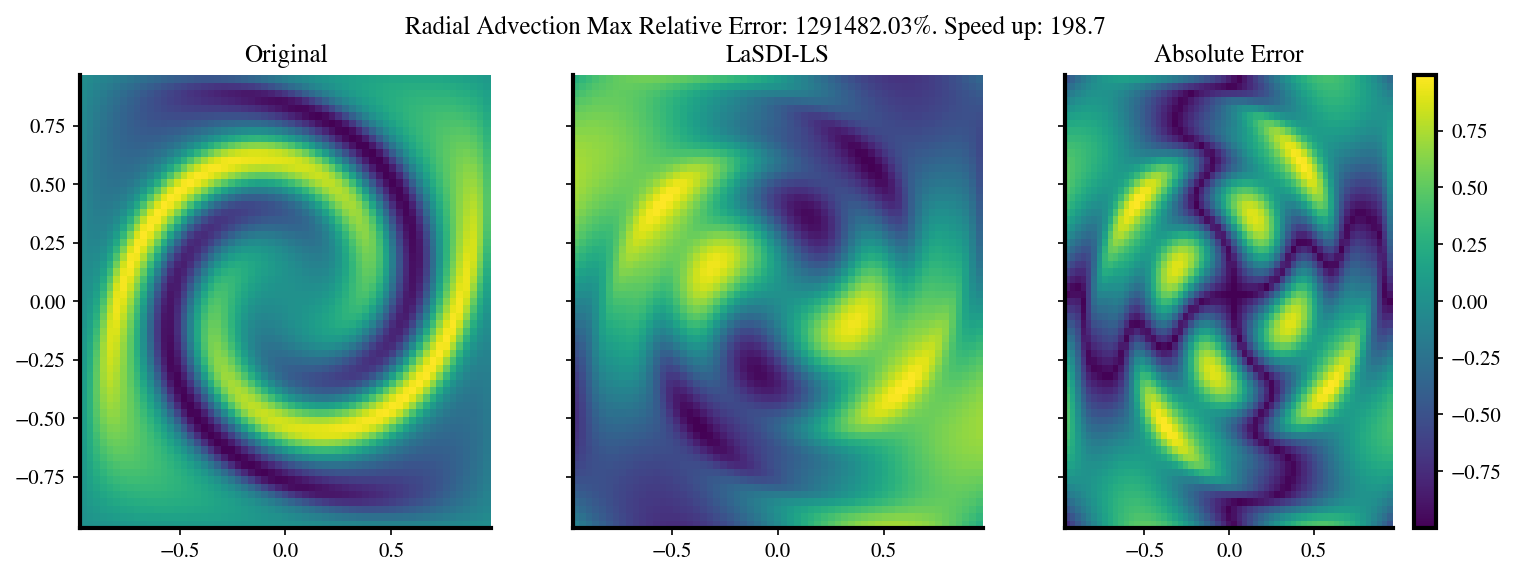

In [12]:
k = -1
plt.rcParams['figure.dpi'] = 150
# plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey = True)
fig.set_size_inches(12,4)

# ax1 = fig.add_subplot(2,3,1)
z=ax1.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax1)
fig.suptitle('Radial Advection Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
ax1.set_title('Original')
# ax1.set_ylabel('U')

# ax2 = fig.add_subplot(2,3,2)
z1=ax2.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax2)
ax2.set_title('LaSDI-LS')

# ax3 = fig.add_subplot(2,3,3)
z2=ax3.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon[k].reshape(nx-2,ny-2)-FOM[k].reshape(nx-2,ny-2))/LA.norm(FOM[k].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Relative Error')

Text(0, 0.5, 'Relative Error (%)')

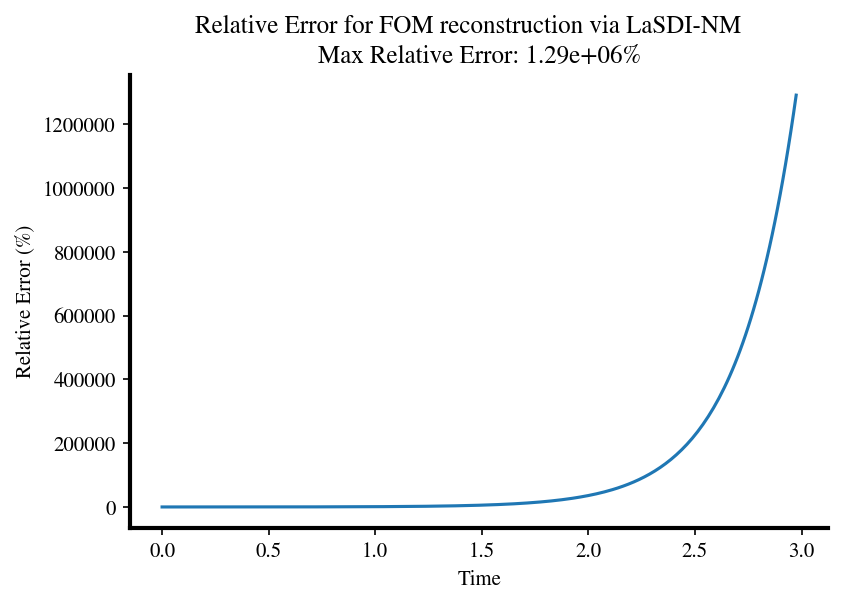

In [13]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t[:-1], test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')


In [ ]:
test[-1]